In [2]:
import pandas as pd
import json
import numpy as np

# make data

In [3]:
with open('data/zac2022_train_merged_final.json',encoding='utf-8') as f:
    data=json.load(f)
    df = pd.json_normalize(data,'data')

In [4]:
df.head()

,id,question,title,text,category,is_long_answer,short_candidate_start,short_candidate,answer
0,718d41cd997b2b44b0685ac54aa55bd8,Thủ tướng Trung Quốc là gì,Trung Quốc,Thủ tướng Trung Quốc là nhân vật lãnh đạo chín...,PARTIAL_ANNOTATION,True,NaN,NaN,NaN
1,c926e7b0717202618a10dd907d4b4c39,Đất nước nào không có quân đội,,"có 23 quốc gia không có lực lượng quân đội, ba...",FULL_ANNOTATION,True,53.0,"Costa Rica, Iceland, Panama, Micronesia, Quần ...",wiki/Danh_sách_quốc_gia_không_có_lực_lượng_vũ_...
2,d38ef5bf1fb82b410026ed82c8a44cae,Pháp tấn công xâm lược Việt Nam vào ngày tháng...,Raymondienne,Raymondienne (hay Raymonde Dien) sinh ngày 13 ...,FALSE_LONG_ANSWER,False,NaN,NaN,NaN
3,b6b5589a98fdccd208dc752bac853993,Cờ vua còn có tên gọi nào khác,Cúp cờ vua thế giới,Cúp cờ vua thế giới là tên gọi một số giải đấu...,FALSE_LONG_ANSWER,False,NaN,NaN,NaN
4,82396a18fa9812bfec4d3ecb7ae60905,Núi nào cao nhất châu âu,Shkhara,Đỉnh núi nằm ở phần trung tâm của dãy núi Đại ...,FULL_ANNOTATION,True,73.0,núi Elbrus,wiki/Elbrus


In [5]:
text_file = open("vietnamese-stopwords.txt", "r")
stopwords = text_file.read().split('\n')
stopwords[:5]

['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy']

In [6]:
import re

def checkdate(date):
    # reg1 = ngày .. tháng .. năm ..
    # reg2 = tháng .. năm ..
    # reg3 = năm ..
    # reg4 = ngày .. tháng ..
    # check date by reg1, reg2, reg3, reg4
    reg1 = r'ngày\s\d{1,2}\stháng\s\d{1,2}\snăm\s\d{4}'
    reg2 = r'tháng\s\d{1,2}\snăm\s\d{4}'
    reg3 = r'năm\s\d{4}'
    reg4 = r'ngày\s\d{1,2}\stháng\s\d{1,2}'
    if re.match(reg1, date) or re.match(reg2, date) or re.match(reg3, date) or re.match(reg4, date):
        return True
    return False

def appy_func(x):
    if x.startswith('wiki/'):
        return 'wiki'
    if x.isdigit():
        return 'number'
    return 'text'

full_df = df.copy()
# full_df = df[df['category']=='FULL_ANNOTATION']

# loop through all row
# create new empty column
full_df['train_label'] = ''


date_keyword = [
    'ngày nào',
    'tháng nào',
    'năm nào',
    'thế nào',
    'khi nào',
    'lúc nào'
]
for index, row in full_df.iterrows():
    for date in date_keyword:
        if date in row['question'].lower():
            full_df.at[index, 'train_label'] = 'text'
            break

    if 'bao nhiêu' in row['question'].lower() and 'năm bao nhiêu' not in row['question'].lower():
        full_df.loc[index, 'train_label'] = 'number'

    if row['category']=='FULL_ANNOTATION':
        full_df.loc[index, 'train_label'] = appy_func(row['answer'])
full_df = full_df[full_df['train_label']!='']
# full_df['train_label'] = full_df['answer'].apply(appy_func)

In [6]:
print('bao nhiêu', len(df[df['question'].str.lower().str.contains('bao nhiêu')]))

bao nhiêu 2228


In [7]:
for keyword in date_keyword:
    print(keyword, len(df[df['question'].str.lower().str.contains(keyword)]))

ngày nào 158
tháng nào 7
năm nào 1463
thế nào 57
khi nào 137
lúc nào 3


In [8]:
full_df['train_label'].value_counts()

wiki      4608
number    2010
text      1885
Name: train_label, dtype: int64

# train bruh bruhh

In [9]:
import tensorflow as tf
import string
import scipy
from tensorflow.keras import layers
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [10]:
train_df = full_df[['question','train_label']]
# question
s1 = u'ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ'
s0 = u'AAAAEEEIIOOOOUUYaaaaeeeiioooouuyAaDdIiUuOoUuAaAaAaAaAaAaAaAaAaAaAaAaEeEeEeEeEeEeEeEeIiIiOoOoOoOoOoOoOoOoOoOoOoOoUuUuUuUuUuUuUuYyYyYyYy'
def remove_accents(input_str):
	s = ''
	for c in input_str:
		if c in s1:
			s += s0[s1.index(c)]
		else:
			s += c
	return s
# train_df['question'] = train_df['question'].apply(remove_accents)

# label
LABEL={
	'wiki':0,
	'number':1,
	'text':2
}
train_df['train_label'] = train_df['train_label'].apply(lambda x: LABEL[x])
train_df.head()

C:\Users\ngoph\AppData\Local\Temp\ipykernel_10520\2716060377.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['train_label'] = train_df['train_label'].apply(lambda x: LABEL[x])


,question,train_label
1,Đất nước nào không có quân đội,0
2,Pháp tấn công xâm lược Việt Nam vào ngày tháng...,2
4,Núi nào cao nhất châu âu,0
8,Hà Nội đã trải qua bao nhiêu lần đổi tên,1
9,Thành phố nào là thủ phủ của Ai Cập trong đế q...,0


In [11]:
train_dataset, test_dataset = train_test_split(train_df, test_size=0.15, random_state=42,
                                                  stratify=train_df['train_label'])

# convert to tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset['question'].values, train_dataset['train_label'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset['question'].values, test_dataset['train_label'].values))

In [12]:
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [13]:
BUFFER_SIZE = 100
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy()[:3])
  print('label: ', label.numpy()[:3])

text:  [b'V\xe1\xbb\x8b vua n\xc3\xa0o n\xc6\xb0\xe1\xbb\x9bc ta l\xe1\xba\xa5y ni\xc3\xaan hi\xe1\xbb\x87u c\xc3\xb3 \xc3\xbd ngh\xc4\xa9a l\xc3\xa0 \xc3\xa1nh s\xc3\xa1ng \xe1\xbb\x9f trung t\xc3\xa2m?'
 b'Th\xc3\xa0nh ph\xe1\xbb\x91 n\xc3\xa0o \xc4\x91\xc3\xb4ng d\xc3\xa2n nh\xe1\xba\xa5t Vi\xe1\xbb\x87t Nam'
 b't\xe1\xbb\x89nh n\xc3\xa0o hi\xe1\xbb\x87n nay t\xe1\xbb\xabng l\xc3\xa0 kinh \xc4\x91\xc3\xb4 c\xe1\xbb\xa7a nh\xc3\xa0 n\xc6\xb0\xe1\xbb\x9bc v\xc4\x83n lang']
label:  [0 0 0]


In [15]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [16]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'nào', 'là', 'của', 'bao', 'nhiêu', 'năm', 'có',
       'nam', 'việt', 'ở', 'thành', 'được', 'nước', 'vào', 'quốc', 'tỉnh',
       'nhất', 'ai'], dtype='<U14')

In [17]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  56,   28,    2,   14,   46,  367,  428,  189,    8,  816,  177,
           3, 1306,  190,   11,   49,  356],
       [  12,   21,    2,  188,   32,   18,   10,    9,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  17,    2,   24,   36,   89,    3,  130,   43,    4,   35,   14,
          88,  884,    0,    0,    0,    0]], dtype=int64)

In [18]:
for n in range(3):
  print("Original: ", example[n].numpy().decode('utf-8'))
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  Vị vua nào nước ta lấy niên hiệu có ý nghĩa là ánh sáng ở trung tâm?
Round-trip:  vị vua nào nước ta lấy niên hiệu có ý nghĩa là ánh sáng ở trung tâm

Original:  Thành phố nào đông dân nhất Việt Nam
Round-trip:  thành phố nào đông dân nhất việt nam         

Original:  tỉnh nào hiện nay từng là kinh đô của nhà nước văn lang
Round-trip:  tỉnh nào hiện nay từng là kinh đô của nhà nước văn lang    



In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         370048    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                        

In [20]:
label_list = list(LABEL.keys())

In [21]:
sample_text = ['Ai là người đầu tiên đặt chân lên mặt trăng',
              'Pháp tấn công xâm lược Việt Nam khi nào',
              'Quốc kỳ Việt Nam có bao nhiêu màu',
              'Có bao nhiêu tỉnh thành owr Việt Nam',
              'Thành phố nào là thủ phủ của Ai Cập trong đế quốc La Mã']

predictions = model.predict(np.array(sample_text))
for pred in predictions:
  print(pred,np.argmax(pred), label_list[np.argmax(pred)])

1/1 [==============================] - 5s 5s/step
[0.33459845 0.33322304 0.33217844] 0 wiki
[0.33398518 0.3349008  0.33111396] 1 number
[0.33316368 0.33337575 0.33346057] 2 text
[0.33285755 0.33403617 0.33310625] 1 number
[0.33363396 0.33424118 0.33212486] 1 number


In [22]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-4),       
                metrics=['accuracy'])

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True)

In [24]:
history = model.fit(train_dataset, epochs=50,
                    validation_data=test_dataset,
                    callbacks=[early_stopping])

Epoch 1/50
113/113 [==============================] - 15s 47ms/step - loss: 0.9747 - accuracy: 0.5698 - val_loss: 0.6082 - val_accuracy: 0.7382
Epoch 2/50
113/113 [==============================] - 2s 21ms/step - loss: 0.2872 - accuracy: 0.9287 - val_loss: 0.1406 - val_accuracy: 0.9781
Epoch 3/50
113/113 [==============================] - 2s 21ms/step - loss: 0.1086 - accuracy: 0.9841 - val_loss: 0.1168 - val_accuracy: 0.9804
Epoch 4/50
113/113 [==============================] - 2s 20ms/step - loss: 0.0818 - accuracy: 0.9887 - val_loss: 0.1082 - val_accuracy: 0.9804
Epoch 5/50
113/113 [==============================] - 2s 21ms/step - loss: 0.0676 - accuracy: 0.9905 - val_loss: 0.0986 - val_accuracy: 0.9796
Epoch 6/50
113/113 [==============================] - 2s 21ms/step - loss: 0.0516 - accuracy: 0.9920 - val_loss: 0.0936 - val_accuracy: 0.9820
Epoch 7/50
113/113 [==============================] - 2s 20ms/step - loss: 0.0461 - accuracy: 0.9924 - val_loss: 0.0890 - val_accuracy: 0.983

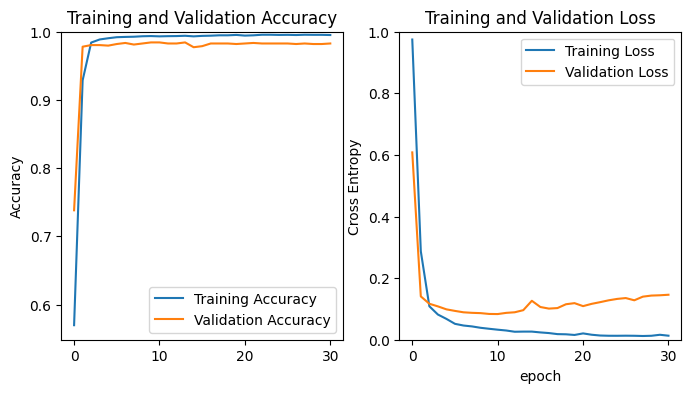

In [25]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
loss, accuracy = model.evaluate(test_dataset)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

20/20 [==============================] - 0s 8ms/step - loss: 0.1398 - accuracy: 0.9828
Loss:  0.13983359932899475
Accuracy:  0.982758641242981


In [27]:
# classfication report
y_pred = model.predict(test_dataset)

20/20 [==============================] - 3s 12ms/step


In [32]:
sample_text = [
    'Ai là người đầu tiên đặt chân lên mặt trăng',
    'Thời đại Hồng Bàng còn có tên gọi khác là gì',
    'Thành phố nào là thủ phủ của Ai Cập trong đế quốc La Mã',
    'Vật lý nghiên cứu vấn đề gì',
    'Có bao nhiêu tỉnh thành ở Việt Nam',
    'Quốc kỳ Việt Nam có bao nhiêu màu',
    'Hà Nội có bao nhiêu đơn vị hành chính',
    'Đinh Đức Thiện mất ngày nào',
    'Ngày quốc thế phụ nữ có từ khi nào',
    'Google thành lập khi nào',
    'Google phát hành cổ phiếu lần đầu vào năm bao nhiêu',
    'Pháp tấn công xâm lược Việt Nam khi nào',
    'năm nào',
    'ngày nào',
    'tháng nào',
    'Ai là người tìm ra châu phi',
    'Có bao nhiêu nước không có vua',
    'Songoku là nhân vật ở phim nào',
    'Anya sinh năm mấy',
    'Anya tóc màu gì',
    'Anya có mấy thú cưng',
    'Anya có mấy skill',
    'Tây Du Ký phiên bản Trương Kỷ Trung khởi quay năm nào'
]

predictions = model.predict(np.array(sample_text))
for i, pred in enumerate(predictions):
    print(sample_text[i], '->', label_list[np.argmax(pred)],max(pred))


1/1 [==============================] - 0s 50ms/step
Ai là người đầu tiên đặt chân lên mặt trăng -> wiki 0.9999999
Thời đại Hồng Bàng còn có tên gọi khác là gì -> wiki 0.99999964
Thành phố nào là thủ phủ của Ai Cập trong đế quốc La Mã -> wiki 1.0
Vật lý nghiên cứu vấn đề gì -> wiki 0.9999553
Có bao nhiêu tỉnh thành ở Việt Nam -> number 0.9999876
Quốc kỳ Việt Nam có bao nhiêu màu -> number 0.99996245
Hà Nội có bao nhiêu đơn vị hành chính -> number 0.99998116
Đinh Đức Thiện mất ngày nào -> text 0.99963176
Ngày quốc thế phụ nữ có từ khi nào -> text 0.996689
Google thành lập khi nào -> text 0.9982864
Google phát hành cổ phiếu lần đầu vào năm bao nhiêu -> number 0.9940398
Pháp tấn công xâm lược Việt Nam khi nào -> text 0.9998318
năm nào -> text 0.7395279
ngày nào -> text 0.7543165
tháng nào -> text 0.7140073
Ai là người tìm ra châu phi -> wiki 0.9999989
Có bao nhiêu nước không có vua -> number 0.99992347
Songoku là nhân vật ở phim nào -> wiki 0.99192554
Anya sinh năm mấy -> text 0.86550397
A

In [29]:
# classficaiton report
from sklearn.metrics import classification_report
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
test_label = np.concatenate([y for x, y in test_dataset], axis=0)
print(classification_report(test_label, y_pred, target_names=label_list))

20/20 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

        wiki       1.00      0.99      0.99       691
      number       0.97      0.97      0.97       302
        text       0.96      0.97      0.96       283

    accuracy                           0.98      1276
   macro avg       0.98      0.98      0.98      1276
weighted avg       0.98      0.98      0.98      1276



In [30]:
model.save('model_1')

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets
